<a href="https://colab.research.google.com/github/davetew/EnergyMarketTools/blob/master/DG_System_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distributed Generation (DG) Thermo-economic Performance Evaluation
This notebook contains the thermo-economic performance evaluation of a number of potential DG systems, with the Levelized Cost of Electricity (LCOE) being the primary performance metric.

The distributed systems evaluated include--
1.  Solar PhotoVoltaic (PV),
2.  Solar PV with "nearly firm" storage,
3.  Fuel cells (FC),
4.  Internal combustion engines (ICE), and
5.  Ultra-high efficiency fuel cell/engine hybrid systems (e.g. ARPA-E INTEGRATE)

## LCOE
The LCOE may be expressed as follows for both "fueled" and "unfueled" (e.g. PV) sysems--   

$$LCOE = \frac{CRF*C_{system} + C^{fixed}_{maint}}{H_{annual}} + c^{variable}_{maint} + \frac{c_{gas}}{\eta_{elec}}\left( 1 - \frac{\eta_{therm}U_{therm}}{\eta^{base}_{therm}}\right)$$

   
*   $C_{system}$ is the installed capital cost of the system in $\frac{$}{kW}$.
*   $CRF$ is the [capital recovery factor](https://en.wikipedia.org/wiki/Capital_recovery_factor).
*   $H_{annual}$ annual number of operating hours. 
*   $C^{fixed}_{maint}$ is the fixed annual cost of maintenance in $\frac{\$}{kW-year}$
*   $c^{variable}_{maint}$ is the variable cost of maintenance in $\frac{$}{kWh}$.
*   $c_{gas}$ is the cost of fuel/gas in $\frac{$}{kWh}$.
*   $\eta_{elec}$ is the fuel to electric conversion efficiency--assumed to $\infty$ for PV systems.
*   $\eta_{therm}$ is the thermal efficiency of the system.
*   $U_{therm}$ is the thermal capacity utilization.
*   $\eta^{base}_{therm}$ is the thermal efficiency of the baseline heating system, whose fuel usage is being offset by waste heat recovery from the DG system.

The fuel to electric conversion efficiency is assumed to be $\infty$ for "unfueled" systems.

### PV Systems without Storage
For PV systems without storage, the LCOE expression simplifies to--

$$LCOE = \frac{CRF*C_{system} + C^{fixed}_{maint}}{8760*CF}$$.

$CF$ is the capacity factor and varies between 0 and 1.  $C_{system}$ is the power-specific installed cost of the PV system (e.g. $C_{system}=C_{PV}=\$2/kW$).

### PV Systems with 'Nearly-Firm' Storage
For PV systems with 'nearly-firm' storage, the PV and storage systems are sized such that the storage system may be fully charged during the portion of the day in which the PV system is active.  

For instance, if $CF=0.2$, then the PV array must be 1/CF times (5X) the nominal (assumed constant) load, and the storage system must be sized to provide the nominal load for a duration of 24*(1-CF) hours.

As such, the (assumed constant) output-power-specific cost of the combined generation and storage system may be expressed as,

\begin{align}
C_{system} & = C_{generation} + C_{storage} \\
 & = \frac{C_{PV}}{CF} + C_{battery}*24*(1-CF)
\end{align}

The system is given by
$$LCOE = \frac{CRF*C_{system} + C^{fixed}_{maint}}{8760} + c^{variable}_{maint}$$.

## References

NREL's [PVWatts](https://pvwatts.nrel.gov/pvwatts.php) calculator will be used to provide hourly estimates of the available AC electric power that could be provided by a system of given capacity (e.g. N kW) in a specified location (e.g. New York, NY).
 

In [ ]:
#@title Importing the required colab-standard Python modules
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE, titleweight="bold")     # font size & weight of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, titleweight="bold")    # font size & weight of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE, titleweight="bold") 

import seaborn as sns
import pandas as pd
import datetime

In [ ]:
#@title Installing and importing the `pint` unit manager
"""Install and import the pint unit manager"""
!pip install pint
import pint

# Ignore pint unit strip warnings
import warnings
warnings.filterwarnings("ignore", message="The unit of the quantity is stripped.")

# Save default unit registry in ureg & Quantity in Q_
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

# Facilitate plotting with matplot
ureg.setup_matplotlib(True)

# Define a currency dimension with usd (US dollar) as the base unit
ureg.define('usd = [currency]')

     |████████████████████████████████| 194kB 9.1MB/s 


In [ ]:
#@title Installing and importing the custom EIA `EnergyMarketTools` module from [Github](https://github.com/davetew/EnergyMarketTools)
# Install EIA Github library
#!pip install git+https://github.com/davetew/EnergyMarketTools.git
!pip install --upgrade git+https://github.com/davetew/EnergyMarketTools.git

from EnergyMarketTools.EIADataQuery_pd import EIAQuery, EIAStateQuery
from EnergyMarketTools.DGValueProp import SensitivityStudy
from EnergyMarketTools.DGMarketStudy import MarketStudy
from EnergyMarketTools.getAnnualCPI import getAnnualCPI

  Cloning https://github.com/davetew/EnergyMarketTools.git to /tmp/pip-req-build-ju8g_x3w
  Running command git clone -q https://github.com/davetew/EnergyMarketTools.git /tmp/pip-req-build-ju8g_x3w
  Created wheel for EnergyMarketTools: filename=EnergyMarketTools-0.1-cp36-none-any.whl size=16782 sha256=3a3ba6db449d4b10a78fb1593dd21ca197daa717a3469b6cdd5c1cb2c64b146e
  Stored in directory: /tmp/pip-ephem-wheel-cache-zbd1k4u3/wheels/3e/4b/95/c9c1f4ba83436e1de4d5495447bbf5e043d8f7b98ef99fb7d8
Successfully built EnergyMarketTools


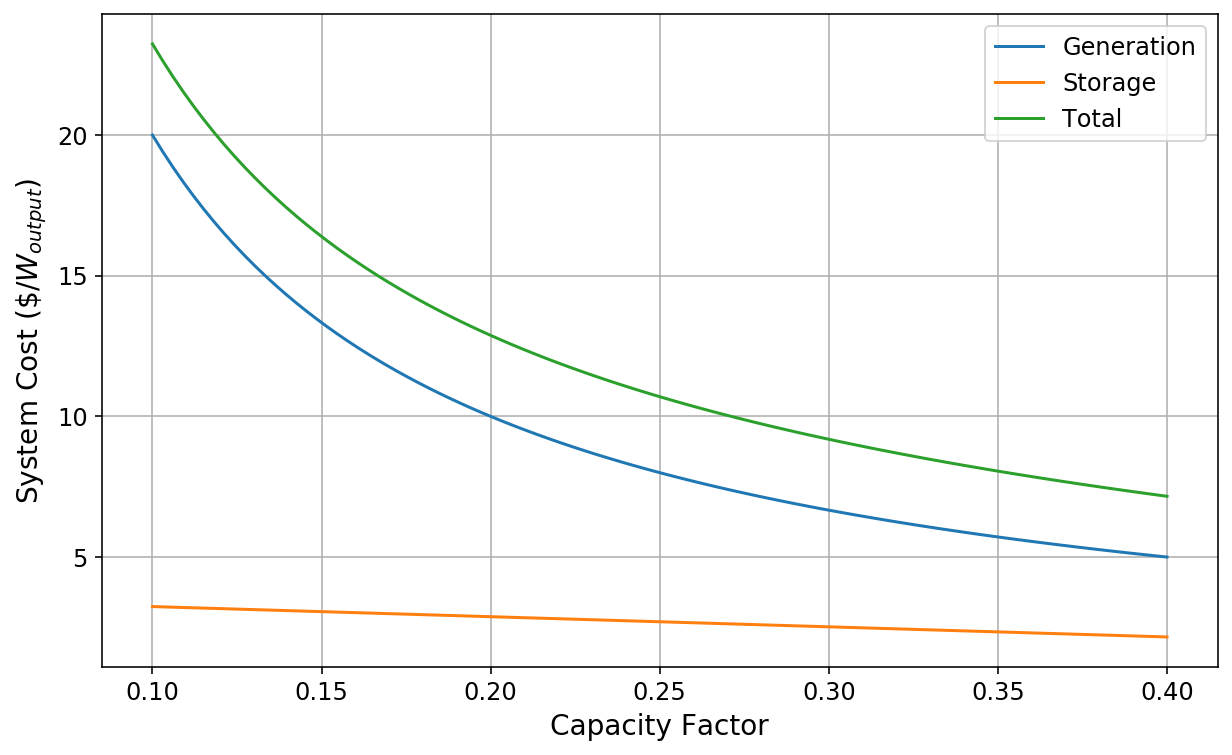

In [ ]:
"""Evaluate the sensitivity of the cost of the 'nearly-firm' PV with storage system to the capacity factor"""
CF = np.linspace(0.1,0.4,100)
c_pv_usd_W = 2 
c_battery_usd_Wh = 0.150

c_generation = np.zeros_like(CF); c_storage = np.zeros_like(CF); 
c_system = np.zeros_like(CF)
for i, cf in enumerate(CF):
  c_generation[i] = c_pv_usd_W/cf
  c_storage[i] = c_battery_usd_Wh*24*(1-cf)
  c_system[i] = c_generation[i] + c_storage[i]

plt.figure(figsize=(10,6))
plt.plot(CF,c_generation, label='Generation')
plt.plot(CF,c_storage, label='Storage')
plt.plot(CF,c_generation + c_storage, label="Total")
plt.xlabel('Capacity Factor')
plt.ylabel('System Cost ($\$/W_{output}$)')
plt.legend(); plt.grid(); plt.show() 

In [ ]:
def discount_factor(discount_rate=0.15, life=Q_(20, 'years')):
  """Calculate and return the discount factor"""
  return np.sum(1/(1+discount_rate)**np.array(range(1,life+1)))

def capital_recovery_factor(discount_rate=0.15, life=Q_(20, 'years')):
  return discount_rate*(1+discount_rate)**life.magnitude / ( (1+discount_rate)**life.magnitude - 1 )

def storage_system(utilization, storage_cost=Q_(150, 'usd/kWh')):
  """Calculate the storage system size (hours) and generation-system-specific
  cost ($/W)"""
  size = 24*ureg.hours*(1-utilization)
  cost = size*storage_cost
  return size, cost.to('usd/W')

def LCOE(generation_cost=Q_(1.9, 'usd/W'), electric_efficiency=0.7, 
         electric_capacity_utilization=0.8, c_maint_fixed=Q_(0, 'usd/kW'), 
         c_maint_variable=Q_(0.02, 'usd/kWh'), c_gas=Q_(0.02, 'usd/kWh'), 
         discount_rate=0.15, life=Q_(20, 'years'), 
         storage=False, storage_cost=Q_(150, "usd/kWh")):
  """Calculate & return the levelized cost of electricity as a pandas Series. Given the
  -capital_cost: installed capital cost of the generation portion of the system,
  -electric_efficiency: fuel to electric conversion efficiency (infinite in the case of
    fuel-free systems),
  -electric_capacity_utilization: annual average capacity utilization,
  -c_maint_fixed: fixed annual cost of maintenance (e.g. $/kW)
  -c_maint_variable: variable cost of maintenance (e.g. $/kWh),
  -c_gas: cost of gas,
  -c_maint: cost of maintenance,
  -discount_rate: discount rate,
  -life: useful operating life of the system,
  -storage: a Boolean flag indicating whether or not storage should be included,
  -battery_cost: the energy-specific cost of assumed battery storage"""

  if storage:
    storage_size, storage_cost = storage_system(electric_capacity_utilization, storage_cost)
    generation_cost = generation_cost/electric_capacity_utilization
    annual_operating_hours = Q_(8760, 'hours')

  else:
    storage_size, storage_cost = Q_(0, 'hours'), Q_(0, 'usd/kW')
    generation_cost = generation_cost
    annual_operating_hours = electric_capacity_utilization*Q_(8760, 'hours')

  # Calculate each individual contribution to LCOE
  LCOE = {'generation_capital': (capital_recovery_factor(discount_rate, life)*generation_cost/annual_operating_hours).to('usd/kWh'),
          'storage_capital': (capital_recovery_factor(discount_rate, life)*storage_cost/annual_operating_hours).to('usd/kWh'),
          'fixed_maintenance':  (c_maint_fixed/annual_operating_hours).to('usd/kWh'),
          'variable_maintenance': c_maint_variable.to('usd/kWh'),
          'fuel_cost': (c_gas/electric_efficiency).to('usd/kWh')}
  
  # Sum the individual contributions to LCOE to calculate the total
  LCOE_total = 0
  for cost in LCOE.values():
    LCOE_total += cost

  # Add it to the dictionary
  LCOE['total'] = LCOE_total

  return pd.Series(LCOE)

   Successfully retrieved--> Electricity price in the commercial sector, United States
   Successfully retrieved--> Natural gas price in the commercial sector, United States
   Successfully retrieved--> Electricity consumed by (i.e., sold to) the commercial sector, United States


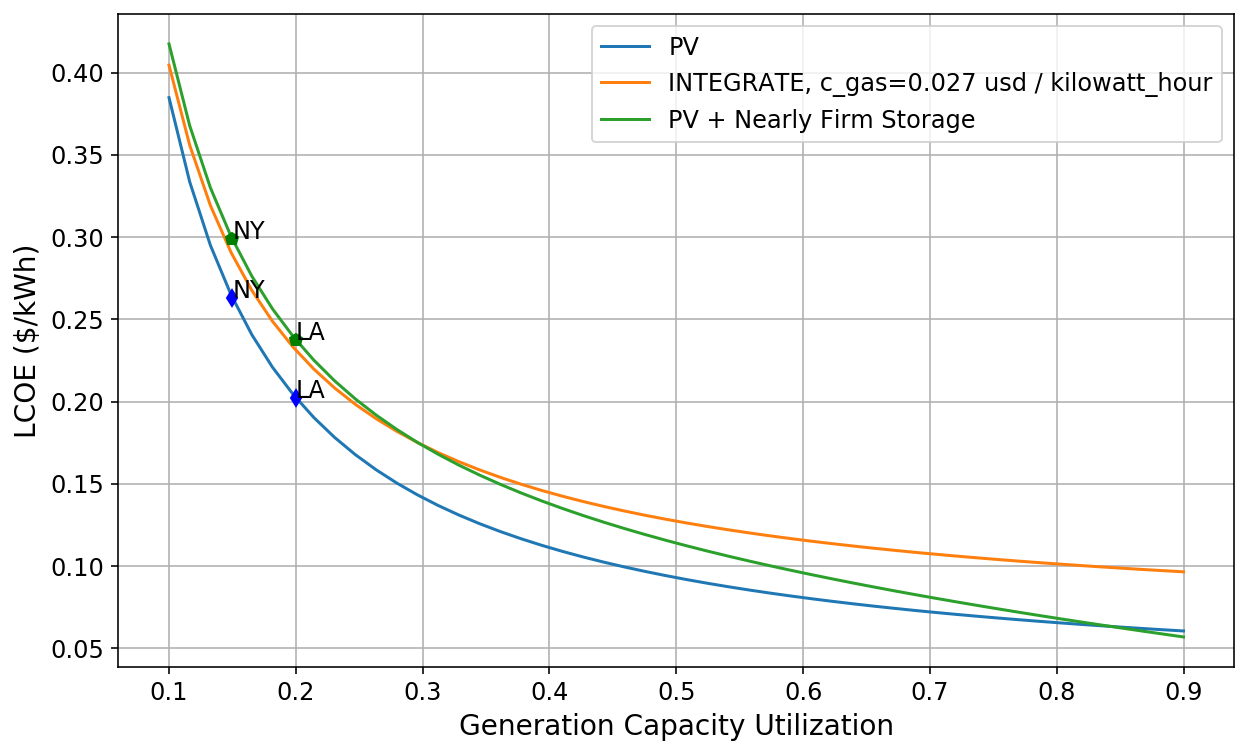

In [ ]:
"""Run capacity utilization sensitivity studies for PV & INTEGRATE-type systems"""

elec_cap_util = np.linspace(0.1, 0.9)

PV_LCOE = [LCOE(electric_efficiency=1e6,
                electric_capacity_utilization=utilization, 
                c_maint_fixed=Q_(16, 'usd/kW')).total.magnitude for utilization in elec_cap_util]

PV_LCOE_storage = [LCOE(electric_efficiency=1e6,
                        electric_capacity_utilization=utilization, 
                        c_maint_fixed=Q_(16, 'usd/kW'), c_maint_variable=Q_(0.01, 'usd/kWh'),
                        storage=True).total.magnitude for utilization in elec_cap_util]

# Calculate city specific PV LCOEs
city_elec_cap_util = {'NY': 0.15, 'LA': 0.2}

city_PV_LCOE = {}; city_PV_LCOE_storage = {}
for city, ecu in city_elec_cap_util.items():
  # City-specific PV
  city_PV_LCOE[city] = LCOE(electric_efficiency=1e6,
                            electric_capacity_utilization=ecu, 
                            c_maint_fixed=Q_(16, 'usd/kW')).total.magnitude 

  # City-specific PV with storage
  city_PV_LCOE_storage[city] = LCOE(electric_efficiency=1e6,
                                    electric_capacity_utilization=ecu, 
                                    c_maint_fixed=Q_(16, 'usd/kW'), 
                                    c_maint_variable=Q_(0.01, 'usd/kWh'),
                                    storage=True).total.magnitude 

# Get US-average commercial rates
CommRates = EIAStateQuery('US')
CommRates.DataFrame = CommRates.DataFrame.dropna(axis=0)
c_gas = CommRates.DataFrame['NG_Rate_dol_kWh'].iloc[-1]*ureg.usd/ureg.kWh

INTEGRATE_LCOE = [LCOE(electric_efficiency=0.7,
                    electric_capacity_utilization=utilization, 
                    c_maint_variable=Q_(0.02, 'usd/kWh'), c_gas=c_gas).total.magnitude for utilization in elec_cap_util]

plt.figure(figsize=(10,6))
plt.plot(elec_cap_util, PV_LCOE, label='PV')
plt.plot(elec_cap_util, INTEGRATE_LCOE, label=f'INTEGRATE, c_gas={c_gas:.3f}')
plt.plot(elec_cap_util, PV_LCOE_storage, label='PV + Nearly Firm Storage')
for city in city_elec_cap_util.keys():
  plt.plot(city_elec_cap_util[city], city_PV_LCOE[city],'bd')
  plt.annotate(city, (city_elec_cap_util[city], city_PV_LCOE[city]))
for city in city_elec_cap_util.keys():
  plt.plot(city_elec_cap_util[city], city_PV_LCOE_storage[city],'gp')
  plt.annotate(city, (city_elec_cap_util[city], city_PV_LCOE_storage[city]))
plt.xlabel('Generation Capacity Utilization')
plt.ylabel('LCOE ($/kWh)')
plt.legend(); plt.grid(); plt.show()

In [ ]:
def getPVCapacityData(datafile, plotData=False):
  """Load hourly PV capacity data from specified location"""
  
  # Read the location meta data
  metaData = pd.read_csv(datafile, header=0, nrows=15, index_col=0, usecols=[0,1], names=['Item','Data'])
  #display(metaData)

  # Get the site solar capacity data
  solarData = pd.read_csv(datafile, header=16, nrows=8760)
  # display(solarData)

  # Calculate the average capacity utilization
  capacityFactor = solarData['AC System Output (W)'].mean() / float(metaData.loc['DC System Size (kW):','Data']) / 1000

  if plotData:
    plotTitle = metaData.loc['Requested Location:','Data'] + '  CF=' + f'{capacityFactor:.2}'
    plt.figure(figsize=(12,4))
    plt.plot(solarData['AC System Output (W)'] / float(metaData.loc['DC System Size (kW):','Data']) / 1000)
    plt.xlabel('Hour'); plt.ylabel('Actual/Max Output')
    plt.axis([0, 8760, 0, 1.0]); plt.grid()
    plt.title(plotTitle)
    plt.show()

  return {'meta': metaData, 'data': solarData, 'capacityFactor': capacityFactor}

def plotLoadDurationCurves(pvCapacityData):
  """Plot load duration curves for each location in the input data file"""
  plt.figure(figsize=(12,8))
  capacities = np.linspace(0.0,1.0,100)
  for location, data in pvCapacityData.items():
    normCapacity = data['data']['AC System Output (W)'] / float(data['meta'].loc['DC System Size (kW):','Data']) / 1000
    loadDurations = [sum(normCapacity >= cap) / normCapacity.count() 
                      for cap in capacities ]
    label = location + ':  CF=' + str(round(data['capacityFactor'], 3))
    plt.plot(capacities, loadDurations, label=label)
  
  plt.xlabel('Available Load / Max Load'); plt.ylabel('Duration Fraction')
  plt.legend()
  plt.grid(); plt.title('Load Duration Curves')

def plotLCOEbar(LCOEdata, location):
  """Plot an LCOE stack bar chart for each of the systems for the specified location"""
  ax= LCOEdata.loc[:,location].unstack().sort_values(by=['total']).drop('total',
                                                                        axis=1).plot(kind='bar', 
                                                                                      stacked=True, 
                                                                                      figsize=(10,6), 
                                                                                      grid=True)
  ax.set_xlabel('System')
  ax.set_ylabel('LCOE ($/kWh)')
  ax.set_title(location)


## System Thermo-Economic Performance Comparison
This section contains a comparison between the thermo-economic performance of four DG systems in four locations.  The four systems include the following technology options--
1.  PV without storage,
2.  PV with "nearly-firm" storage,
3.  Internal Combustion Engine,
4.  Fuel Cell, and
5.  An INTEGRATE fuel cell/engine hybrid system.

The four locations considered include--
1.  New York,
2.  Los Angeles,
3.  Miami, and
4.  Seattle.

The location specifications are used to calculate the PV capacity factors with [PVWatts](https://pvwatts.nrel.gov) and to determine the commercial gas rate, which is assumed to be the latest available EIA state-average for the state in which the specified city is located.

,PV - No Storage,PV - Firm Storage,ICE,Fuel Cell - SOA,INTEGRATE - Targets
generation_cost,2 usd / watt,2 usd / watt,3 usd / watt,6.6 usd / watt,2 usd / watt
storage_cost,0 usd / kilowatt_hour,300 usd / kilowatt_hour,0 usd / kilowatt_hour,0 usd / kilowatt_hour,0 usd / kilowatt_hour
electric_efficiency,1e+06,1e+06,0.33,0.54,0.7
electric_capacity_utilization,None,None,0.9,0.9,0.9
c_maint_fixed,16 usd / kilowatt,16 usd / kilowatt,0.0 usd / kilowatt,340 usd / kilowatt,0.0 usd / kilowatt
c_maint_variable,0 usd / kilowatt_hour,0.01 usd / kilowatt_hour,0.025 usd / kilowatt_hour,0.0 usd / kilowatt_hour,0.02 usd / kilowatt_hour
storage,False,True,False,False,False


   Successfully retrieved--> Electricity price in the commercial sector, New York
   Successfully retrieved--> Natural gas price in the commercial sector, New York
   Successfully retrieved--> Electricity consumed by (i.e., sold to) the commercial sector, New York
   Successfully retrieved--> Electricity price in the commercial sector, California
   Successfully retrieved--> Natural gas price in the commercial sector, California
   Successfully retrieved--> Electricity consumed by (i.e., sold to) the commercial sector, California
   Successfully retrieved--> Electricity price in the commercial sector, Florida
   Successfully retrieved--> Natural gas price in the commercial sector, Florida
   Successfully retrieved--> Electricity consumed by (i.e., sold to) the commercial sector, Florida
   Successfully retrieved--> Electricity price in the commercial sector, Washington
   Successfully retrieved--> Natural gas price in the commercial sector, Washington
   Successfully retrieved--> Elect

NY    LA  Miami  Seattle
System              Cost Element                                    
PV - No Storage     generation_capital    0.24  0.19   0.20     0.29
                    storage_capital       0.00  0.00   0.00     0.00
                    fixed_maintenance     0.01  0.01   0.01     0.01
                    variable_maintenance  0.00  0.00   0.00     0.00
                    fuel_cost             0.00  0.00   0.00     0.00
                    total                 0.26  0.20   0.21     0.31
PV - Firm Storage   generation_capital    0.24  0.19   0.20     0.29
                    storage_capital       0.11  0.11   0.11     0.11
                    fixed_maintenance     0.00  0.00   0.00     0.00
                    variable_maintenance  0.01  0.01   0.01     0.01
                    fuel_cost             0.00  0.00   0.00     0.00
                    total                 0.37  0.31   0.32     0.42
ICE                 generation_capital    0.06  0.06   0.06     0.06
                    storage_capital       0.00  0.00   0.00     0.00
                    fixed_maintenance     0.00  0.00   0.00     0.00
                    variable_maintenance  0.03  0.03   0.03     0.03
                    fuel_cost             0.07  0.09   0.11     0.08
                    total                 0.15  0.17   0.20     0.17
Fuel Cell - SOA     generation_capital    0.13  0.13   0.13     0.13
                    storage_capital       0.00  0.00   0.00     0.00
                    fixed_maintenance     0.04  0.04   0.04     0.04
                    variable_maintenance  0.00  0.00   0.00     0.00
                    fuel_cost             0.04  0.05   0.07     0.05
                    total                 0.22  0.23   0.24     0.23
INTEGRATE - Targets generation_capital    0.04  0.04   0.04     0.04
                    storage_capital       0.00  0.00   0.00     0.00
                    fixed_maintenance     0.00  0.00   0.00     0.00
                    variable_maintenance  0.02  0.02   0.02     0.02
                    fuel_cost             0.03  0.04   0.05     0.04
                    total                 0.09  0.10   0.11     0.10

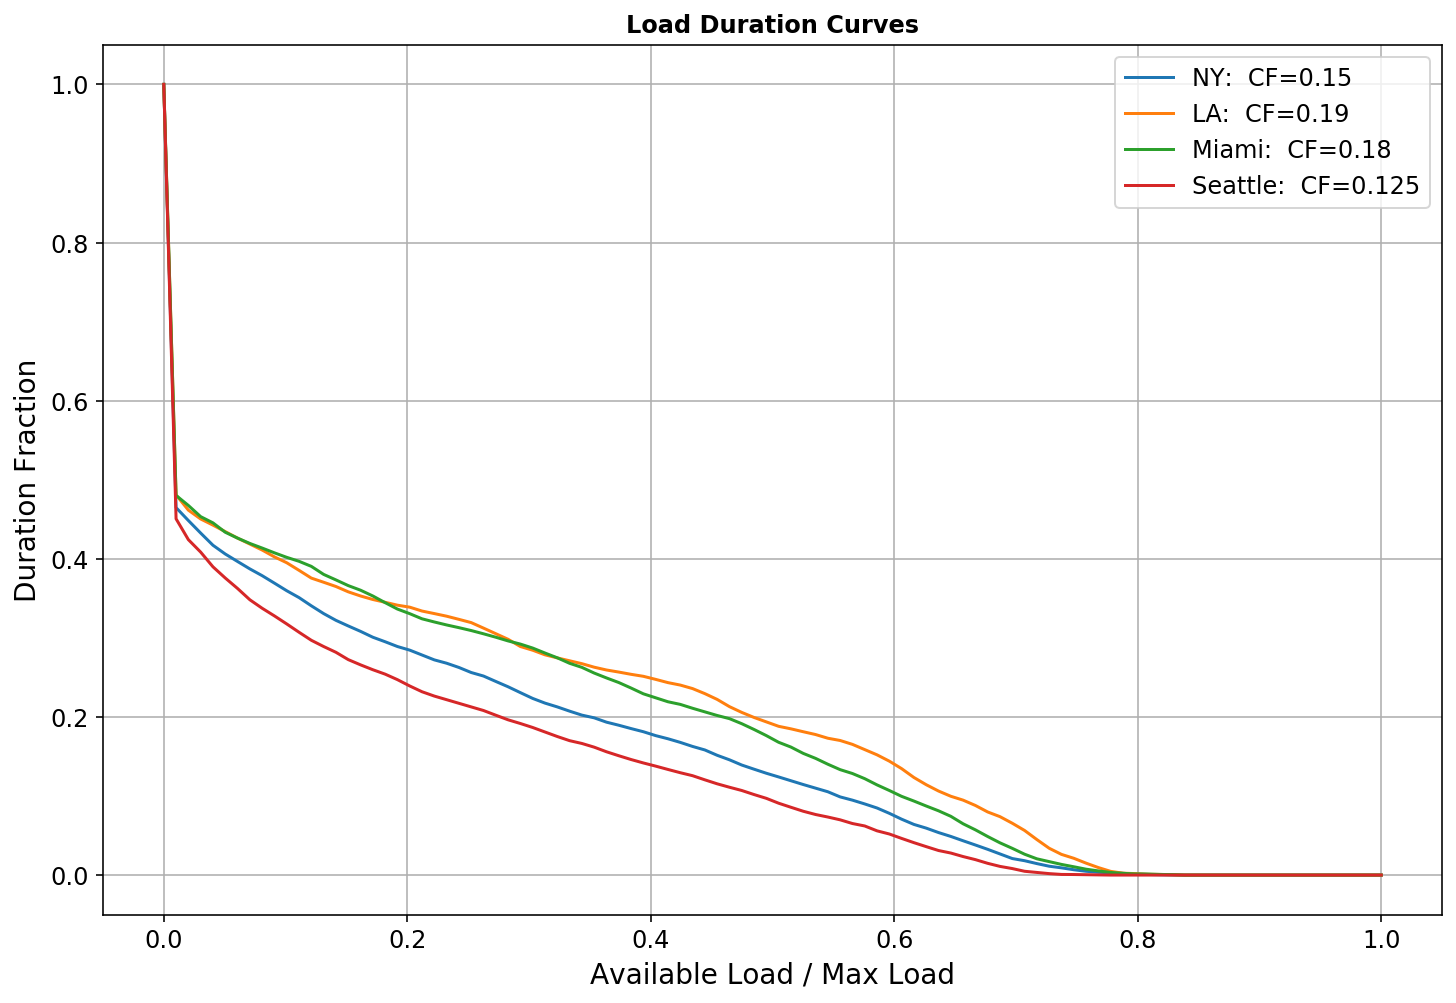

In [ ]:
"""Run regional scenario assessments"""

# Location-specific PV capacity data
pvCapacityDataFiles = {'NY': 'https://raw.githubusercontent.com/davetew/Solar-Design-Tools/master/Solar-Data/pvwatts_NY_1kW.csv?token=AEHJ446G23OLGQRAKIUV2RS6ENQRO',
                        'LA': 'https://raw.githubusercontent.com/davetew/Solar-Design-Tools/master/Solar-Data/pvwatts_LA_1kW.csv?token=AEHJ443NPZCYCJIVNLMVNL26ENQTG',
                        'Miami': 'https://raw.githubusercontent.com/davetew/Solar-Design-Tools/master/Solar-Data/pvwatts_Miami_1kW.csv?token=AEHJ447VBKE2SYQUXVEMFNK6ENVFQ', 
                        'Seattle': 'https://raw.githubusercontent.com/davetew/Solar-Design-Tools/master/Solar-Data/pvwatts_Seattle_1kW.csv?token=AEHJ443AHB27IEWF4Z7JVX26ENQZO'}

# System specifications
systemSpecs = {'PV - No Storage': {'generation_cost': Q_(2, 'usd/W'),
                                   'storage_cost': Q_(0, 'usd/kWh'),
                                   'electric_efficiency': 1e6,
                                   'electric_capacity_utilization': None,
                                   'c_maint_fixed': Q_(16, 'usd/kW'),
                                   'c_maint_variable': Q_(0, 'usd/kWh'),
                                   'storage': False},
               'PV - Firm Storage': {'generation_cost': Q_(2, 'usd/W'),
                                    'storage_cost': Q_(300, 'usd/kWh'),
                                    'electric_efficiency': 1e6,
                                    'electric_capacity_utilization': None, 
                                    'c_maint_fixed': Q_(16, 'usd/kW'),
                                    'c_maint_variable': Q_(0.01, 'usd/kWh'),
                                    'storage': True},
               'ICE': {'generation_cost': Q_(3, 'usd/W'),
                       'storage_cost': Q_(0, 'usd/kWh'),
                        'electric_efficiency': 0.33,
                        'electric_capacity_utilization': 0.9,
                        'c_maint_fixed': Q_(0.0, 'usd/kW'),
                        'c_maint_variable': Q_(0.025, 'usd/kWh'),
                        'storage': False},
               'Fuel Cell - SOA': {'generation_cost': Q_(6.6, 'usd/W'),
                                    'storage_cost': Q_(0, 'usd/kWh'),
                                    'electric_efficiency': 0.54,
                                    'electric_capacity_utilization': 0.9,
                                    'c_maint_fixed': Q_(340, 'usd/kW'),
                                    'c_maint_variable': Q_(0.0, 'usd/kWh'),
                                    'storage': False},
               'INTEGRATE - Targets': {'generation_cost': Q_(2, 'usd/W'),
                                        'storage_cost': Q_(0, 'usd/kWh'),
                                        'electric_efficiency': 0.7,
                                        'electric_capacity_utilization': 0.9,
                                        'c_maint_fixed': Q_(0.0, 'usd/kW'),
                                        'c_maint_variable': Q_(0.02, 'usd/kWh'),
                                        'storage': False} }

# Display the system specifications
display(pd.DataFrame.from_dict(systemSpecs))

# Calculate the LCOE for each system in each location

# Create an empty dataframe for the data

multiIndex = pd.MultiIndex.from_product([systemSpecs, LCOE().index.values],
                                        names=['System','Cost Element'])
#LCOE_usd_kWh = pd.DataFrame(index=systemSpecs.keys(), columns=pvCapacityDataFiles.keys())
LCOE_usd_kWh = pd.DataFrame(index=multiIndex, columns=pvCapacityDataFiles.keys())

# Create an empty dictionary for the location capacity data
pvCapacityData = {}

for location, datafile in pvCapacityDataFiles.items():
  # Load the capacity data for each of the locations in the data dictionary
  pvCapacityData[location] = getPVCapacityData(datafile, plotData=False)

  # Get the commercial gas rate for the specified state
  state = pvCapacityData[location]['meta'].loc['Requested Location:','Data'][-2:]
  CommRates = EIAStateQuery(state)
  CommRates.DataFrame = CommRates.DataFrame.dropna(axis=0)
  c_gas = CommRates.DataFrame['NG_Rate_dol_kWh'].iloc[-1]*ureg.usd/ureg.kWh
  
  for system, specs in systemSpecs.items():

    if specs['electric_capacity_utilization'] is None:
      cf = pvCapacityData[location]['capacityFactor']
    else:
      cf = specs['electric_capacity_utilization']

    LCOE_usd_kWh.loc[(system, LCOE().index.values), 
                     location] = LCOE(generation_cost=specs['generation_cost'],
                                      storage_cost=specs['storage_cost'],
                                      electric_efficiency=specs['electric_efficiency'],
                                      electric_capacity_utilization=cf,
                                      c_maint_fixed=specs['c_maint_fixed'],
                                      c_maint_variable=specs['c_maint_variable'],
                                      c_gas=c_gas,
                                      storage=specs['storage']).values

# Round costs to the nearest cent and drop the unit labels
LCOE_usd_kWh = LCOE_usd_kWh.apply(lambda x: x.apply(lambda y: round(y.magnitude, 2)))

plotLoadDurationCurves(pvCapacityData)
display(LCOE_usd_kWh)


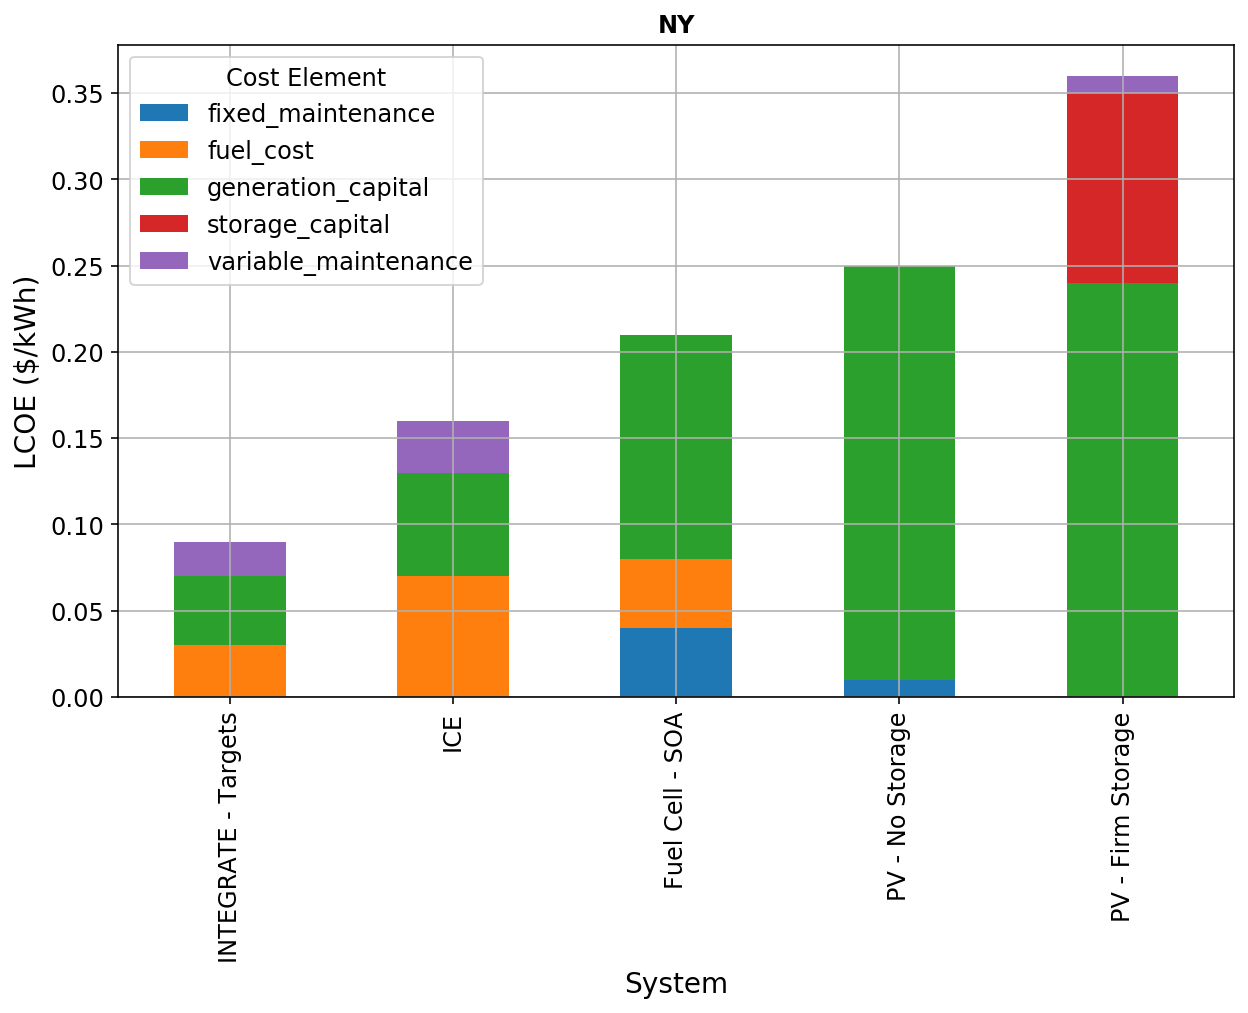

In [ ]:
plotLCOEbar(LCOE_usd_kWh, 'NY')

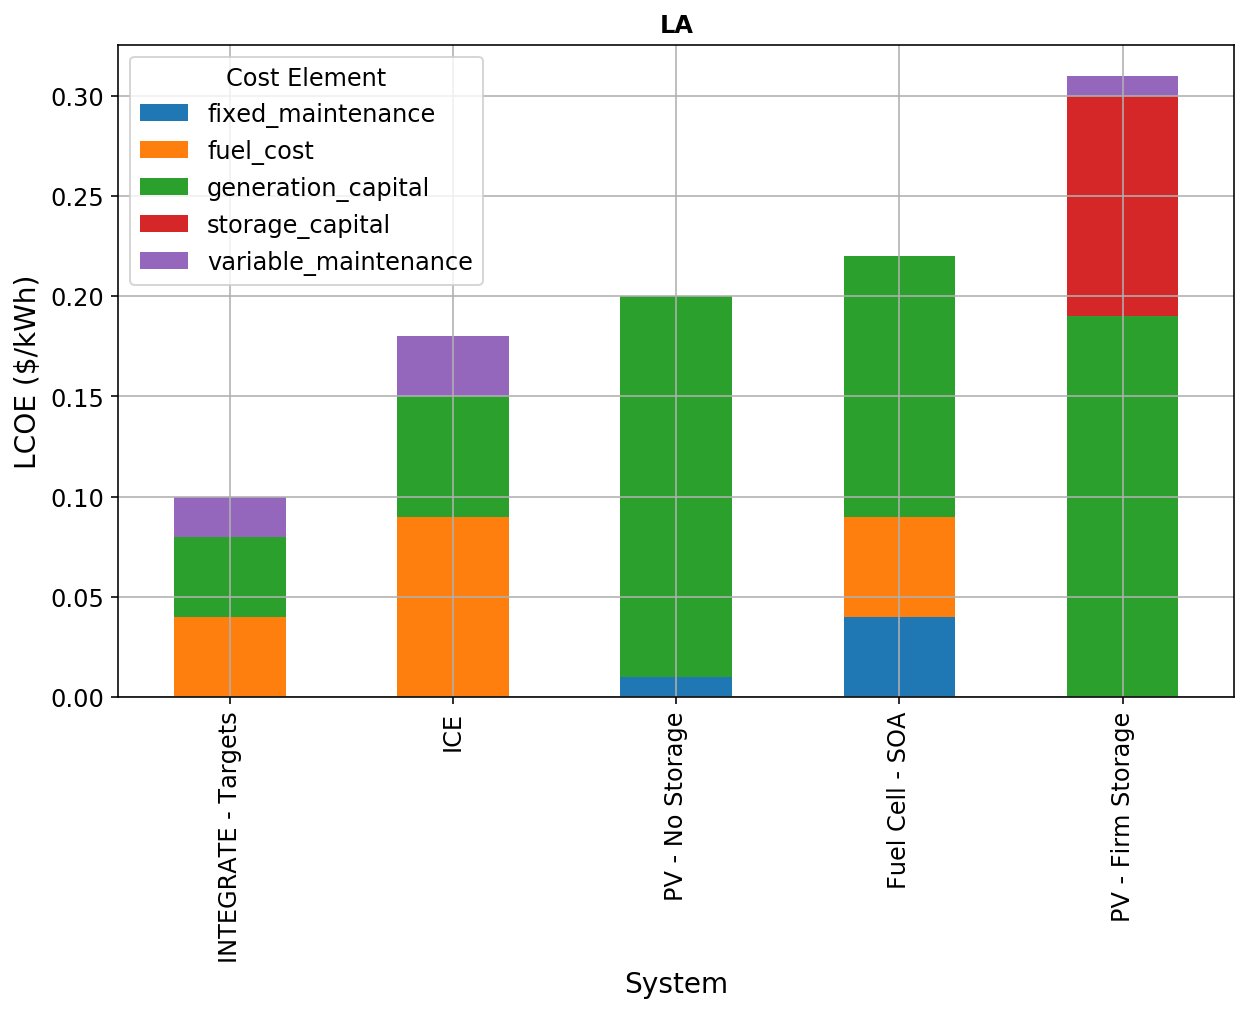

In [ ]:
plotLCOEbar(LCOE_usd_kWh, 'LA')